In [105]:
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import kstest
import scipy.stats as st

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [106]:
sns.set()
matplotlib.rcParams['figure.figsize'] = (12, 7)
pd.set_option('display.float_format','{:.4f}'.format)

# TEST ADF NA STACJONARNOSC

In [107]:
def adf_test(x, alpha=0.05):
    p_val = []
    is_stationary = []
    trend = ['Stała', 'Linia', 'Parabola', 'Brak']
    trends = ['c', 'ct', 'ctt', 'n']

    for i in trends:
        result = adfuller(x, regression=i, autolag='AIC')
        p = result[1]
        p_val.append(p)
        if p < alpha:
            is_stationary.append('Tak')
        else:
            is_stationary.append('Nie')

    return pd.DataFrame({
        'Trend': trend,
        'P-value': p_val,
        f'Stacjonarny (α={alpha})': is_stationary
        })

# TESTY NA NORMALNOŚĆ

In [108]:
import scipy.stats as st

def normality_tests(data):
    # Parametry dla rozkładu normalnego
    loc, sc = st.norm.fit(data)

    # Test Kolmogorova-Smirnova
    ks_result = st.kstest(data, 'norm', args=(loc, sc))
    ks_stat, ks_p_value = ks_result.statistic, ks_result.pvalue
    
    # Test normalności (D'Agostino i Pearson)
    normaltest_stat, normaltest_p_value = st.normaltest(data)

    # Test Shapiro-Wilka
    shapiro_stat, shapiro_p_value = st.shapiro(data)
    print(shapiro_stat,shapiro_p_value)
    
    # Interpretacja wyników
    print("Test Kolmogorova-Smirnova:")
    print(f"Statystyka: {ks_stat:.4f}, p-wartość: {ks_p_value:.4f}")
    print("Wynik testu Kolmogorova-Smirnova:")
    if ks_p_value < 0.05:
        print("Odrzucamy hipotezę zerową: dane nie pochodzą z rozkładu normalnego.")
    else:
        print("Nie ma podstaw do odrzucenia hipotezy zerowej: dane mogą pochodzić z rozkładu normalnego.")
    
    print("\nTest D'Agostino i Pearson:")
    print(f"Statystyka: {normaltest_stat:.4f}, p-wartość: {normaltest_p_value:.4f}")
    print("Wynik testu D'Agostino i Pearson:")
    if normaltest_p_value < 0.05:
        print("Odrzucamy hipotezę zerową: dane nie są normalnie rozłożone.")
    else:
        print("Nie ma podstaw do odrzucenia hipotezy zerowej: dane mogą być normalnie rozłożone.")
    
    print("\nTest Shapiro-Wilka:")
    print(f"Statystyka: {shapiro_stat:.4f}, p-wartość: {shapiro_p_value:.4f}")
    print("Wynik testu Shapiro-Wilka:")
    if shapiro_p_value < 0.05:
        print("Odrzucamy hipotezę zerową: dane nie są normalnie rozłożone.")
    else:
        print("Nie ma podstaw do odrzucenia hipotezy zerowej: dane mogą być normalnie rozłożone.")



In [109]:
def t_student_tests(data):
    # Parametry dla rozkładu t-Studenta
    d_f, loc, sc = st.t.fit(data)
    print(d_f, loc, sc)
    # Test t-Studenta dla średniej
    t_stat, t_p_value = st.ttest_1samp(data, popmean=loc)
    
    # Test Kolmogorova-Smirnova z rozkładem t-Studenta
    ks_stat, ks_p_value = st.kstest(data, st.t(d_f, loc, sc).cdf)
    
    # Interpretacja wyników
    print("Test t-Studenta:")
    print(f"Statystyka t: {t_stat:.4f}, p-wartość: {t_p_value:.4f}")
    print("Wynik testu t-Studenta:")
    if t_p_value < 0.05:
        print("Odrzucamy hipotezę zerową: średnia próby różni się od zadanej wartości.")
    else:
        print("Nie ma podstaw do odrzucenia hipotezy zerowej: średnia próby jest równa zadanej wartości.")
    
    print("\nTest Kolmogorova-Smirnova:")
    print(f"Statystyka: {ks_stat:.4f}, p-wartość: {ks_p_value:.4f}")
    print("Wynik testu Kolmogorova-Smirnova:")
    if ks_p_value < 0.05:
        print("Odrzucamy hipotezę zerową: dane nie pochodzą z rozkładu t-Studenta.")
    else:
        print("Nie ma podstaw do odrzucenia hipotezy zerowej: dane mogą pochodzić z rozkładu t-Studenta.")

# FUNKCJA DO PARAMETRÓW - MIAR RYZYKA

In [110]:
def parametry(X):
    '''funkcja zwraca tabele z wynikami'''
    # główne parametry
    mean = np.mean(X)
    n = len(X)
    
    # odchylenie standardow
    std = np.std(X)
    # odchylenie przeciętne
    przec_std = np.sum(np.abs(X - mean)) / (n-1)
    
    # rozstęp międzykwartylowy
    q = np.quantile(X, [0.25, 0.75])
    rozstep = q[0]-q[1]

    # odchylenie ćwiartkowe
    cwiartk = (q[1] - q[0]) / 2
    
    # semiodchylenie standardowe
    semi_std = np.sqrt(np.sum(X[X -mean>0] ** 2) / (n-1) )
    # semidochylenie przeciętne
    semi_przec = np.sum(np.abs(X[X -mean>0] - mean)) / (n-1)

    # współczynnik zmienności
    zmiennosc = std/mean

    nazwy = ['Odchylenie standardowe', 'Odchylenie przeciętne', 'Rozstęp międzykwartylowy', 'Odchylenie ćwiartkowe', 
             'Semiodchylenie standardowe', 'Semiodchylenie przeciętne', 'Średnia', 'Współczynnik zmienności']
    wartosci = [std, przec_std, rozstep, cwiartk, semi_std, semi_przec, mean, zmiennosc]
    data = pd.DataFrame({'Miara':nazwy, 'Wartość':wartosci})
    return data

N = 100000

In [111]:
def kwantyle(df, title, levels_df=[0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]):
    # wykres
    levels = np.arange(0.01, 1, 0.01)
    q = np.quantile(df, levels)
    sns.lineplot(x=levels, y=q, color = 'black')
    plt.title(f'Wykres kwantylowy dla {title}')
    plt.show()
    
    # tabela z wynikami
    q = np.quantile(df, levels_df)
    data = pd.DataFrame({'Kwantyl':levels_df, 'Wartość':q})
    return data

In [112]:
def wartosc_dystrybuanty(X, wartosci=[0.01, 0.02, 0.05, 0.1, 0.15, 0.2]):
    ecdf = ECDF(X)
    data = pd.DataFrame({'Ustalona wartość':wartosci, 'wartość dystrybuanty':ecdf(wartosci)})
    return data

# Kurs walut

[*********************100%***********************]  1 of 1 completed


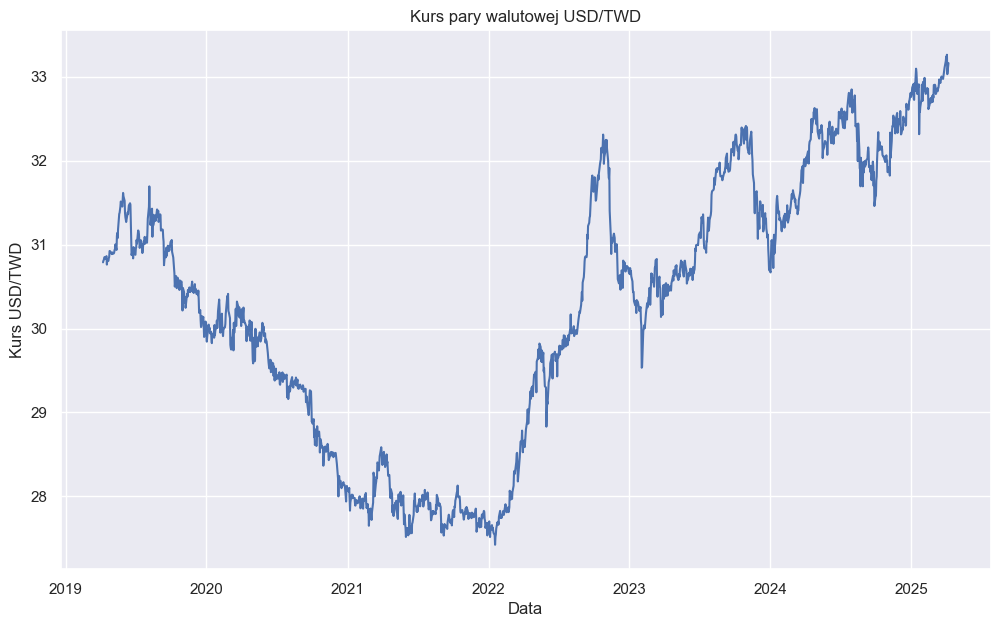

In [113]:
usd_twd = yf.download('USDTWD=X', period='6y')['Close']

plt.plot(usd_twd)
plt.title('Kurs pary walutowej USD/TWD')
plt.ylabel('Kurs USD/TWD')
plt.xlabel('Data')
plt.grid(True)
plt.show()

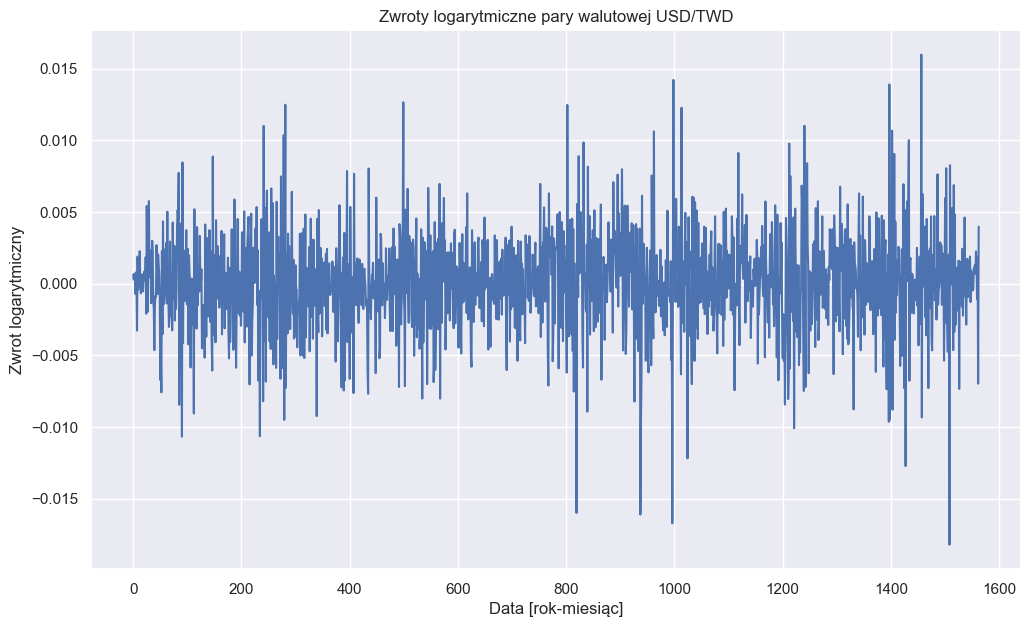

In [114]:
log_returns_usd_twd = np.log(usd_twd / usd_twd.shift(1)).dropna()
log_returns_usd_twd = np.ravel(log_returns_usd_twd)

plt.plot(log_returns_usd_twd)
plt.title('Zwroty logarytmiczne pary walutowej USD/TWD')
plt.ylabel('Zwrot logarytmiczny')
plt.xlabel('Data [rok-miesiąc]')
plt.grid(True)
plt.show()

In [115]:
adf_results = adf_test(log_returns_usd_twd)
print(adf_results)

      Trend  P-value Stacjonarny (α=0.05)
0     Stała   0.0000                  Tak
1     Linia   0.0000                  Tak
2  Parabola   0.0000                  Tak
3      Brak   0.0000                  Tak


____ 
# Analiza jednowymiarowa pary walutowej USD/TWD

## Podejście parametryczne

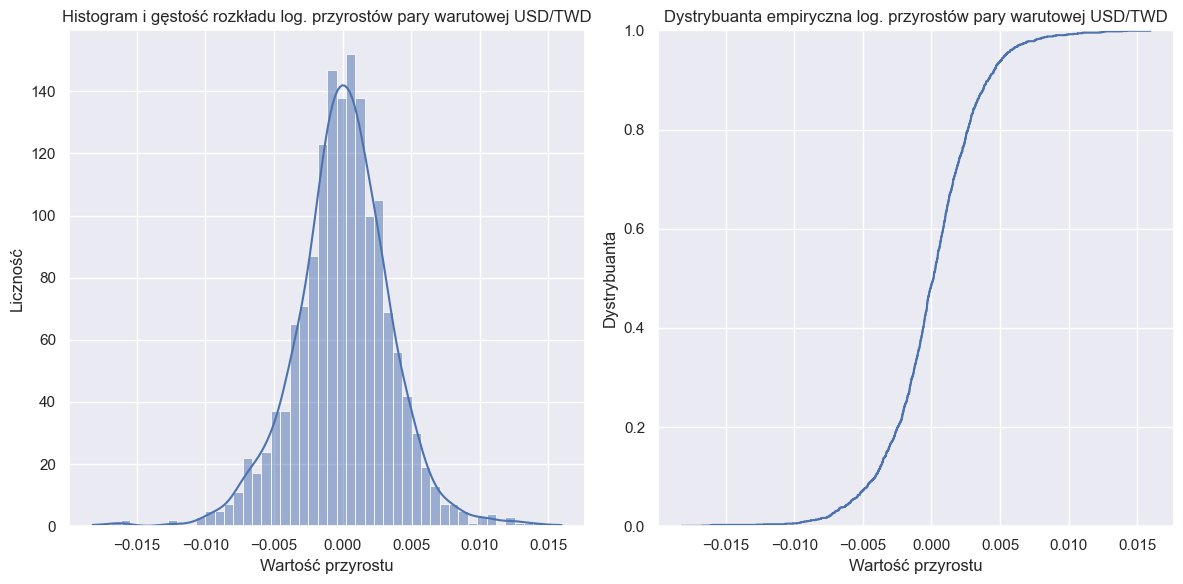

In [116]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Histogram i gęstość rozkładu na pierwszym subplocie
sns.histplot(log_returns_usd_twd, kde=True, ax=axes[0])
axes[0].set_title('Histogram i gęstość rozkładu log. przyrostów pary warutowej USD/TWD')
axes[0].set_xlabel('Wartość przyrostu')
axes[0].set_ylabel('Liczność')

# Dystrybuanta empiryczna na drugim subplocie
sns.ecdfplot(log_returns_usd_twd, ax=axes[1])
axes[1].set_title('Dystrybuanta empiryczna log. przyrostów pary warutowej USD/TWD')
axes[1].set_xlabel('Wartość przyrostu')
axes[1].set_ylabel('Dystrybuanta')

# Wyświetlanie wykresu
plt.tight_layout()
plt.show()


In [117]:
normality_tests(log_returns_usd_twd)

0.9782029617449147 1.159224766625642e-14
Test Kolmogorova-Smirnova:
Statystyka: 0.0485, p-wartość: 0.0012
Wynik testu Kolmogorova-Smirnova:
Odrzucamy hipotezę zerową: dane nie pochodzą z rozkładu normalnego.

Test D'Agostino i Pearson:
Statystyka: 90.9698, p-wartość: 0.0000
Wynik testu D'Agostino i Pearson:
Odrzucamy hipotezę zerową: dane nie są normalnie rozłożone.

Test Shapiro-Wilka:
Statystyka: 0.9782, p-wartość: 0.0000
Wynik testu Shapiro-Wilka:
Odrzucamy hipotezę zerową: dane nie są normalnie rozłożone.


In [118]:
t_student_tests(log_returns_usd_twd)
d_f, loc, sc = st.t.fit(log_returns_usd_twd)

1.9873934807779683 -2.600890792103099e-06 0.00227355546290333
Test t-Studenta:
Statystyka t: 0.5634, p-wartość: 0.5732
Wynik testu t-Studenta:
Nie ma podstaw do odrzucenia hipotezy zerowej: średnia próby jest równa zadanej wartości.

Test Kolmogorova-Smirnova:
Statystyka: 0.0306, p-wartość: 0.1051
Wynik testu Kolmogorova-Smirnova:
Nie ma podstaw do odrzucenia hipotezy zerowej: dane mogą pochodzić z rozkładu t-Studenta.


In [119]:
d_f, loc, sc
d_f = 4

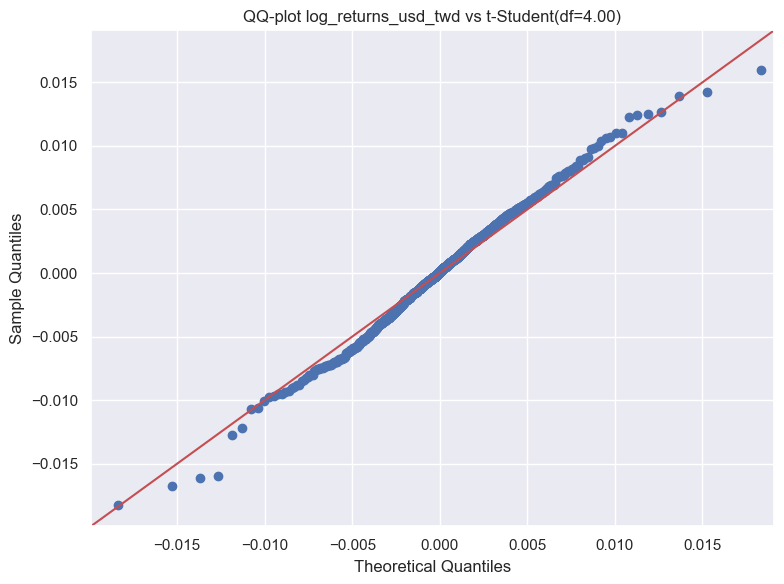

In [120]:
import statsmodels.api as sm

# Upewniamy się, że dane są 1D
log_returns_usd_twd = np.ravel(log_returns_usd_twd)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

sm.qqplot(log_returns_usd_twd, dist=st.t(d_f, loc, sc), line='45', ax=ax)
plt.title(f'QQ-plot log_returns_usd_twd vs t-Student(df={d_f:.2f})')
plt.grid(True)
plt.tight_layout()
plt.show()

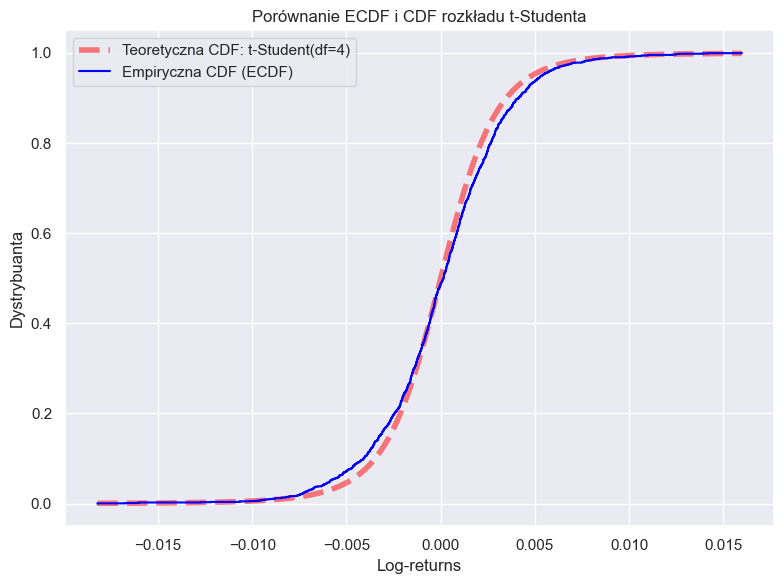

In [121]:
# Empiryczna dystrybuanta
ecdf = ECDF(log_returns_usd_twd)

# Siatka do wykresu
x = np.linspace(min(log_returns_usd_twd), max(log_returns_usd_twd), 1000)
t_cdf = st.t.cdf(x, df=d_f, loc=loc, scale=sc)

# Wykres
plt.figure(figsize=(8, 6))
plt.plot(x, t_cdf, label=f'Teoretyczna CDF: t-Student(df={d_f})', color='red', linewidth=4, alpha=0.5, linestyle='dashed')
plt.step(ecdf.x, ecdf.y, label='Empiryczna CDF (ECDF)', where='post', color='blue')
plt.title('Porównanie ECDF i CDF rozkładu t-Studenta')
plt.xlabel('Log-returns')
plt.ylabel('Dystrybuanta')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [177]:
simulated_data = st.t.rvs(d_f, loc=loc, scale=sc, size=N)
parametry(simulated_data)

,Miara,Wartość
0,Odchylenie standardowe,0.0050
1,Odchylenie przeciętne,0.0035
2,Rozstęp międzykwartylowy,-0.0052
3,Odchylenie ćwiartkowe,0.0026
4,Semiodchylenie standardowe,0.0036
5,Semiodchylenie przeciętne,0.0018
6,Średnia,0.0001
7,Współczynnik zmienności,79.0924


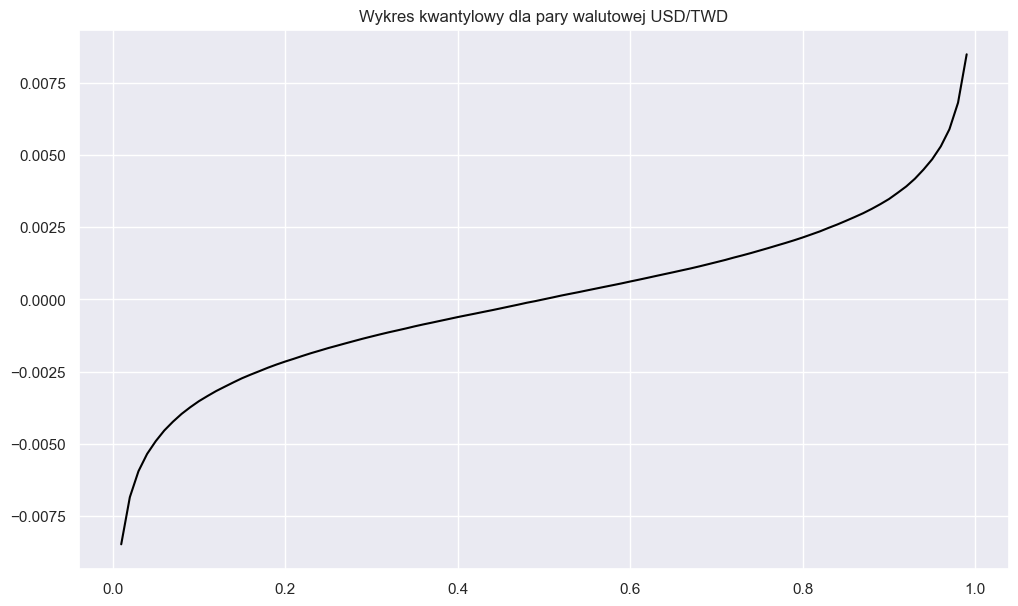

,Kwantyl,Wartość
0,0.0500,-0.0049
1,0.1500,-0.0027
2,0.2500,-0.0017
3,0.3500,-0.0009
4,0.4500,-0.0003
5,0.5500,0.0003
6,0.6500,0.0009
7,0.7500,0.0017
8,0.8500,0.0027
9,0.9500,0.0048


In [123]:
kwantyle(simulated_data, 'pary walutowej USD/TWD')

In [124]:
wartosc_dystrybuanty(simulated_data, [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2])

,Ustalona wartość,wartość dystrybuanty
0,0.0001,0.5147
1,0.0005,0.5812
2,0.0010,0.6590
3,0.0050,0.9535
4,0.0100,0.9941
5,0.0500,1.0000
6,0.1000,1.0000
7,0.2000,1.0000


## Podejście nieparametryczne

In [125]:
parametry(log_returns_usd_twd)

,Miara,Wartość
0,Odchylenie standardowe,0.0035
1,Odchylenie przeciętne,0.0026
2,Rozstęp międzykwartylowy,-0.0040
3,Odchylenie ćwiartkowe,0.0020
4,Semiodchylenie standardowe,0.0025
5,Semiodchylenie przeciętne,0.0013
6,Średnia,0.0000
7,Współczynnik zmienności,73.9848


In [126]:
def kwantyle(df, title, levels_df=[0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]):
    # wykres
    levels = np.arange(0.01, 1, 0.01)
    q = np.quantile(df, levels)
    sns.lineplot(x=levels, y=q)
    plt.title(f'Wykres kwantylowy dla {title}')
    plt.show()
    
    # tabela z wynikami
    q = np.quantile(df, levels_df)
    data = pd.DataFrame({'Kwantyl':levels_df, 'Wartość':q})
    return data

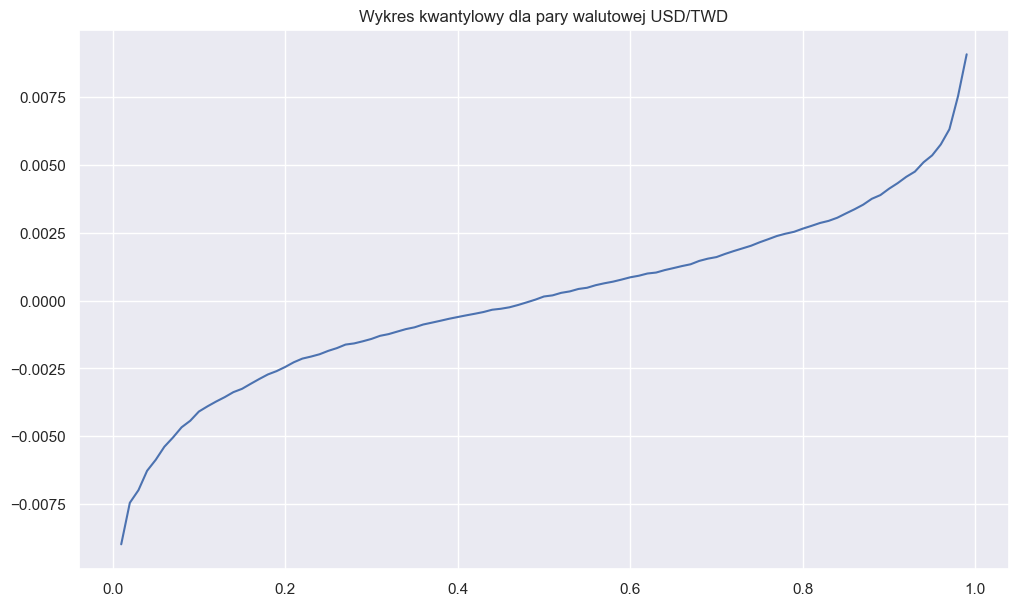

,Kwantyl,Wartość
0,0.0500,-0.0059
1,0.1500,-0.0033
2,0.2500,-0.0019
3,0.3500,-0.0010
4,0.4500,-0.0003
5,0.5500,0.0005
6,0.6500,0.0012
7,0.7500,0.0021
8,0.8500,0.0032
9,0.9500,0.0053


In [127]:
kwantyle(log_returns_usd_twd, 'pary walutowej USD/TWD')

## Wartości dystrybuanty

In [128]:
def wartosc_dystrybuanty(X, wartosci=[0.01, 0.02, 0.05, 0.1, 0.15, 0.2]):
    ecdf = ECDF(X)
    data = pd.DataFrame({'Ustalona wartość':wartosci, 'wartość dystrybuanty':ecdf(wartosci)})
    return data

In [129]:
wartosc_dystrybuanty(log_returns_usd_twd, [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2])

,Ustalona wartość,wartość dystrybuanty
0,0.0001,0.4952
1,0.0005,0.5553
2,0.0010,0.6219
3,0.0050,0.9373
4,0.0100,0.9917
5,0.0500,1.0000
6,0.1000,1.0000
7,0.2000,1.0000


## Podejście parametryczne

In [130]:
loc, sc = st.norm.fit(log_returns_usd_twd)
loc, sc

(np.float64(4.7512606840795105e-05), np.float64(0.0035152095516550776))